# Compare sst_nino3 output from NCL Wavelet, PyWavelets, and Torrence and Compo
### "A Practical Guide to Wavelet Analysis" (Torrence and Compo 1998)
### [sst_nino3.data example based on NCL](https://github.com/NCAR/geocat-scratch/blob/main/geocat-comp/wavelet/wavelet_WORKING.ncl)

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets
import pandas as pd
import math
import cmaps

import pywt # PyWavelets

In [34]:
# Download nino data
#nino_url = 'https://paos.colorado.edu/research/wavelets/wave_idl/nino3sst.txt'
#sst_data = np.genfromtxt(nino_url, skip_header=19)

# Collect Data from Local Source (after downloaded)
sst_data = np.loadtxt("data/nino3sst_trimmed.txt")
time_0 = 1871.0
dt = 0.25  # years (4 per year, seasonal)
time_range = (np.arange(0, len(sst_data)) * dt) + time_0 # from 1871.00 to 1996.75

sst_df = pd.DataFrame({'time (years)': time_range, 'temperature (C)': sst_data})

sst_df.head()

,time (years),temperature (C)
0,1871.00,-0.15
1,1871.25,-0.30
2,1871.50,-0.14
3,1871.75,-0.41
4,1872.00,-0.46


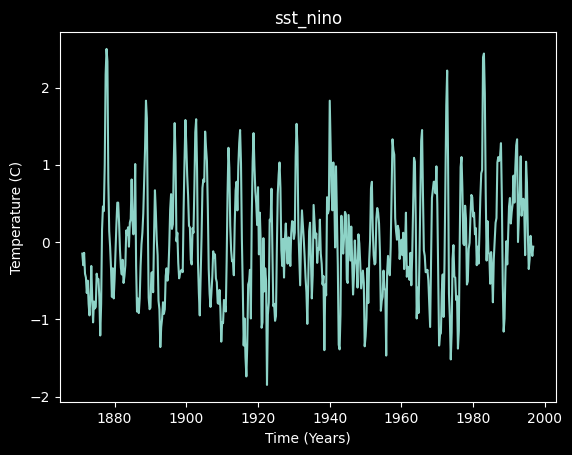

In [35]:
# Plot data
plt.style.use('dark_background')
fig, ax = plt.subplots()
fig = plt.plot(sst_df["time (years)"], sst_df["temperature (C)"])
plt.title("sst_nino")
plt.xlabel("Time (Years)")
plt.ylabel("Temperature (C)")
plt.show()

# Choosing Scales
Large scale correspond to strenched wavelets that are sensitive to low frequency analysis

Small scales correspodn to a squished wavelet that are sensitive to high freqeuncy analysis

PyWavelets = "for example, at scale=10 the wavelet is stretched by a factor of 10, making it sensitive to lower frequencies in the signal...To relate a given scale to a specific signal frequency, the sampling period of the signal must be known. pywt.scale2frequency() can be used to convert a list of scales to their corresponding frequencies. The proper choice of scales depends on the chosen wavelet, so pywt.scale2frequency() should be used to get an idea of an appropriate range for the signal of interest."

In [36]:
# pywavelets scale2frequency(wavelet, scale)/ sampling_period
# can be used to determine what the physical frequency f is
# f is in hertz when using a sampling_period in seconds

## Plot 1: Power Spectrum
Wavelet_coeff is a complex numbre with a real and an imaginary number (1 + 2i). The power spectrum plots the real component of the complex number

```python
real_component = np.log2(np.square(abs(wavelet_coeffs)))
```

The real component represents the magntiude of the wavelet coefficient

size (64, 504) with 64 scales and 504 time steps
x-axis (time) be default is: 504
y-axis (scale) be default is: 64


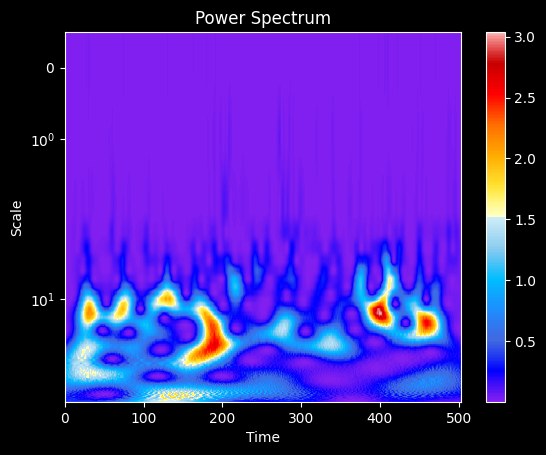

In [55]:
#wavelet_mother = "cmor" # cmorB-C where BC are floating point values
# B = bandwith
# C = center frequency
#wavelet_mother = f"cmor{B}-{C}"
wavelet_mother = "cmor1.5-1.0" # Morlet in Torrence/Compo cooresponds to cmor in PyWavelets -> https://github.com/PyWavelets/pywt/issues/522#issuecomment-539227912

dt = 0.25 # sampling period (time between each y-value)
s0 = 0.25 # smallest scale
dj = 0.25 # spacing between discrete scales
n = len(sst_data)
jtot = 64
scales = np.arange(1, jtot+1)
wavelet_coeffs, freqs = pywt.cwt(data=sst_data,
                                 scales=scales,
                                 wavelet=wavelet_mother,
                                 sampling_period=dt)

# Shape of wavelet transform
print(f"size {wavelet_coeffs.shape} with {wavelet_coeffs.shape[0]} scales and {wavelet_coeffs.shape[1]} time steps")
print(f"x-axis (time) be default is: {wavelet_coeffs.shape[1]}")
print(f"y-axis (scale) be default is: {wavelet_coeffs.shape[0]}")

# Plot scalogram
fig, ax = plt.subplots()
plt.style.use('dark_background')
power = np.power((abs(wavelet_coeffs)), 2)  # compare the power spectrum

ax.set_yscale("symlog")
plt.title("Power Spectrum")
plt.xlabel("Time")
plt.ylabel("Scale")
plt.imshow(power, 
           vmax=(power).max(), vmin=(power).min(),
           cmap=cmaps.ncl_default, aspect="auto")
plt.colorbar()
plt.savefig("ncl_colors.png")
plt.show()

## Plot 2: Phase Spectrum
Wavelet_coeff is a complex numbre with a real and an imaginary number (1 + 2i). The less common phase plot uses the imaginary component of the complex number

```python
import numpy as np

# note: np.angle() returns the angle of a complex argument

imaginary_component = np.angle(wavelet_coeffs)
```

The imaginary component represents the direction of the wavelet coefficient

size (64, 504) with 64 scales and 504 time steps
x-axis (time) be default is: 504
y-axis (scale) be default is: 64


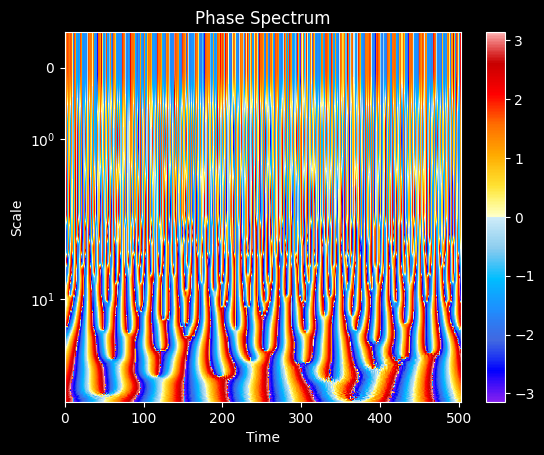

In [63]:
wavelet_mother = "cmor1.5-1.0" # Morlet in Torrence/Compo cooresponds to cmor in PyWavelets -> https://github.com/PyWavelets/pywt/issues/522#issuecomment-539227912

dt = 0.25 # sampling period (time between each y-value)
s0 = 0.25 # smallest scale
dj = 0.25 # spacing between discrete scales
n = len(sst_data)
jtot = 64
scales = np.arange(1, jtot+1)
wavelet_coeffs, freqs = pywt.cwt(data=sst_data,
                                 scales=scales,
                                 wavelet=wavelet_mother)

# Shape of wavelet transform
print(f"size {wavelet_coeffs.shape} with {wavelet_coeffs.shape[0]} scales and {wavelet_coeffs.shape[1]} time steps")
print(f"x-axis (time) be default is: {wavelet_coeffs.shape[1]}")
print(f"y-axis (scale) be default is: {wavelet_coeffs.shape[0]}")

# Plot scalogram
fig, ax = plt.subplots()
plt.style.use('dark_background')
data = np.angle(wavelet_coeffs)

ax.set_yscale("symlog")
plt.title("Phase Spectrum")
plt.xlabel("Time")
plt.ylabel("Scale")
plt.imshow(data, 
           vmax=(data).max(), vmin=(data).min(),
           cmap=cmaps.ncl_default, aspect="auto")
plt.colorbar()
plt.show()

## Cone of Influence

Errors occur at the edges of a wavelet power spectrum where discontinuties occur between wavelets, so the Cone of Influence displays which values on a plot are considered signficant. "The cone of influence is the region of the wavelet specrum in which edge effects beome important and is defined here as the e-folding time for the autocorrelation of wavelet power at each scale" (Torrence and Compo 1998)

For each wavelet type there is an"e-folding time for autocorrelation of wavelet power at each scale" where "the wavelet power for a discontinuity at the edge drops by a factor e^-2 and ensures that the edge effects are neglibigle beyond this point" (Torrence and Compo 1998)

The region close to the start and end of the data where the edge effect may impact the data

```python
# e_folding_time varies based on wavelet
e_folding_factor = 1/e_folding_time
```
Represents the time over which the edge effect decays

In [41]:
# wavelets
# https://github.com/ct6502/wavelets/blob/e345f33a61becfb6c4850317d31c75b0da10d9e9/wave_python/waveletFunctions.py#L165
# calculates the reconstruction factor (Torrence and Compo 1998, table 2)
# reconstruction equation 13 from Torrence and Compo
# reconstruction factor "is scale independent and is a constant for each wavelet function" (Torrence and Compo, 68

wavelet = "Morlet"

# built-in parameterse and fourier wavelengths from Torrence and Compo (Table 1)
if wavelet == "Morlet":
    param = 6 # morlet (frequency)
    fourier_wavelength = (4 * np.pi) / (param + np.sqrt(2 + np.square(param)))
    e_folding_time = np.sqrt(2) # Morlet and DOG
if wavelet == "Paul":
    param = 4 # paul  (order)
    fourier_wavelength = (4 * np.pi) / ((2 * param) + 1)
    e_folding_time = 1/np.sqrt(2) # Paul
if wavelet == "DOG":
    param = 2 # DOG (derivative)
    fourier_wavelength = (2 * np.pi) / np.sqrt(param + .5)
    e_folding_time = np.sqrt(2) # Morlet and DOG

e_folding_time = 1/e_folding_time # decay over time (as 1/e)
coi_value = fourier_wavelength * e_folding_time

print(f"fourier_wavelength = {fourier_wavelength}")
print(f"e_folding_time = {e_folding_time}")
print(f"coi_value = {coi_value}")

fourier_wavelength = 1.0330436477492537
e_folding_time = 0.7071067811865475
coi_value = 0.7304721685851844


sst_data length is equal coi length = True


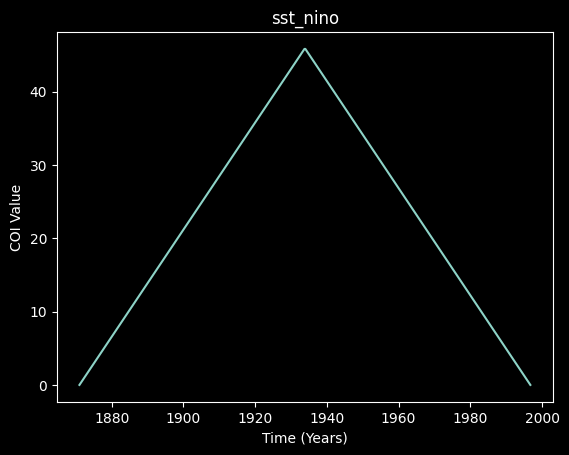

In [42]:
# "determine the cone of influence and the Fourier wavelength at each scale" (Torrence and Compo
# coi mirrored across the second half of the time range
coi_data_first_half  = coi_value * dt * (np.arange(int((len(sst_data) + 1) / 2)))
coi_data = np.concatenate((coi_data_first_half, coi_data_first_half[::-1]))
print(f"sst_data length is equal coi length = {len(sst_data) == len(coi_data)}")
    
coi_df = pd.DataFrame({'time range': time_range,
                                'coi': coi_data})

fig, ax = plt.subplots()
fig = plt.plot(coi_df["time range"], coi_df["coi"])
plt.title("sst_nino")
plt.xlabel("Time (Years)")
plt.ylabel("COI Value")
plt.show()

size (29, 504) with 29 scales and 504 time steps
x-axis (time) be default is: 504
y-axis (scale) be default is: 29


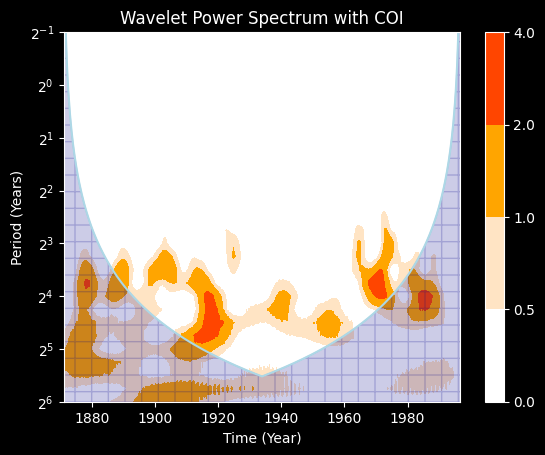

In [60]:
wavelet_mother = "cmor1.5-1.0" # Morlet in Torrence/Compo cooresponds to cmor in PyWavelets -> https://github.com/PyWavelets/pywt/issues/522#issuecomment-539227912

s0 = 2*dt # smallest scale
J1 = 7 / dj
j = np.arange(0, J1 + 1)
scales = s0 * 2 ** (j * dj)
dj = 0.25 # spacing between discrete scales

wavelet_coeffs, freqs = pywt.cwt(data=sst_data,
                                 scales=scales,
                                 wavelet=wavelet_mother)
# Shape of wavelet transform
print(f"size {wavelet_coeffs.shape} with {wavelet_coeffs.shape[0]} scales and {wavelet_coeffs.shape[1]} time steps")
print(f"x-axis (time) be default is: {wavelet_coeffs.shape[1]}")
print(f"y-axis (scale) be default is: {wavelet_coeffs.shape[0]}")

levels = [0, 0.5, 1, 2, 4]
power = np.power((abs(wavelet_coeffs)), 2)  # compare the power spectrum
period = 1 / freqs

import warnings
warnings.filterwarnings('ignore')

fig, ax = plt.subplots()
plt.style.use('dark_background')
CS = plt.contourf(time_range, period, power, len(levels))
im = plt.contourf(CS, levels=levels,
    colors=['white', 'bisque', 'orange', 'orangered', 'darkred'])

# plot COI
plt.fill_between(x=time_range,
                 y1=coi_data * 0 + period[-1],
                 y2=coi_data,
                 edgecolor="darkblue",
                 facecolor="darkblue",
                 alpha=0.2,
                 hatch='+')
plt.plot(time_range, coi_data, 
         color='lightblue')

plt.xlabel("Time (Year)")
plt.ylabel("Period (Years)")
plt.title("Wavelet Power Spectrum with COI")
ax.set_yscale('log', base=2)
plt.ylim([np.min(period), np.max(period)])
ax.invert_yaxis()
plt.colorbar()
plt.show()

## Significance Levels

"The null hypothesis is defined for the wavelet power spectrum as follows: It is assumed that the time series has a mean power spectrum...if a peak in the wavelet power spectrum is significantly above this background spectrum, then it can be assumed to be a true feature with a certain percent confidence. For definitions, “significant at the 5% level” is equivalent to “the 95% confidence level,” and implies a test against a certain background level, while the “95% confidence interval” refers to the range of confidence about a given value." (Torrence and Compo 1998)

size (29, 504) with 29 scales and 504 time steps
x-axis (time) be default is: 504
y-axis (scale) be default is: 29
scale
29
[ 0.5         0.59460356  0.70710678  0.84089642  1.          1.18920712
  1.41421356  1.68179283  2.          2.37841423  2.82842712  3.36358566
  4.          4.75682846  5.65685425  6.72717132  8.          9.51365692
 11.3137085  13.45434264 16.         19.02731384 22.627417   26.90868529
 32.         38.05462768 45.254834   53.81737058 64.        ]
freq
29
[2.         1.68179283 1.41421356 1.18920712 1.         0.84089642
 0.70710678 0.59460356 0.5        0.42044821 0.35355339 0.29730178
 0.25       0.2102241  0.1767767  0.14865089 0.125      0.10511205
 0.08838835 0.07432544 0.0625     0.05255603 0.04419417 0.03716272
 0.03125    0.02627801 0.02209709 0.01858136 0.015625  ]
period
29
[ 0.5         0.59460356  0.70710678  0.84089642  1.          1.18920712
  1.41421356  1.68179283  2.          2.37841423  2.82842712  3.36358566
  4.          4.75682846  5.65685

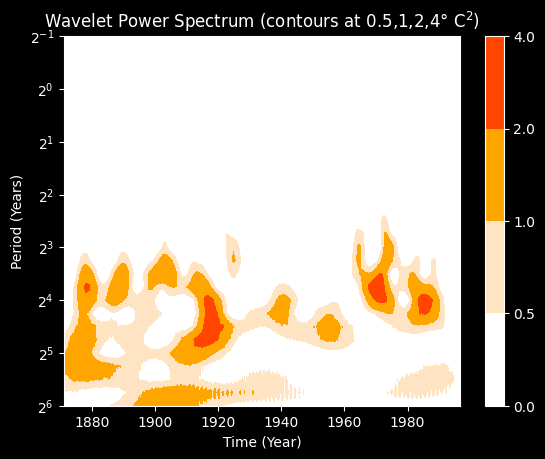

In [61]:
wavelet_mother = "cmor1.5-1.0" # Morlet in Torrence/Compo cooresponds to cmor in PyWavelets -> https://github.com/PyWavelets/pywt/issues/522#issuecomment-539227912

s0 = 2*dt # smallest scale
J1 = 7 / dj
j = np.arange(0, J1 + 1)
scales = s0 * 2 ** (j * dj)
dj = 0.25 # spacing between discrete scales

wavelet_coeffs, freqs = pywt.cwt(data=sst_data,
                                 scales=scales,
                                 wavelet=wavelet_mother)
# Shape of wavelet transform
print(f"size {wavelet_coeffs.shape} with {wavelet_coeffs.shape[0]} scales and {wavelet_coeffs.shape[1]} time steps")
print(f"x-axis (time) be default is: {wavelet_coeffs.shape[1]}")
print(f"y-axis (scale) be default is: {wavelet_coeffs.shape[0]}")

levels = [0, 0.5, 1, 2, 4]
power = np.power((abs(wavelet_coeffs)), 2)  # compare the power spectrum
period = 1 / freqs

print("scale")
print(len(scales))
print(scales)
print("freq")
print(len(freqs))
print(freqs)
print("period")
print(len(period))
print(period)

import warnings
warnings.filterwarnings('ignore')

fig, ax = plt.subplots()
plt.style.use('dark_background')
CS = plt.contourf(time_range, period, power, len(levels))
im = plt.contourf(CS, levels=levels,
    colors=['white', 'bisque', 'orange', 'orangered', 'darkred'])
plt.xlabel('Time (Year)')
plt.ylabel('Period (Years)')
plt.title('Wavelet Power Spectrum (contours at 0.5,1,2,4\u00B0 C$^2$)')
ax.set_yscale('log', base=2)
plt.ylim([np.min(period), np.max(period)])
ax.invert_yaxis()
plt.colorbar()
plt.show()

# Compare NCL to PyWavelets Output

NCL dataframe is the same as the data from paos = True


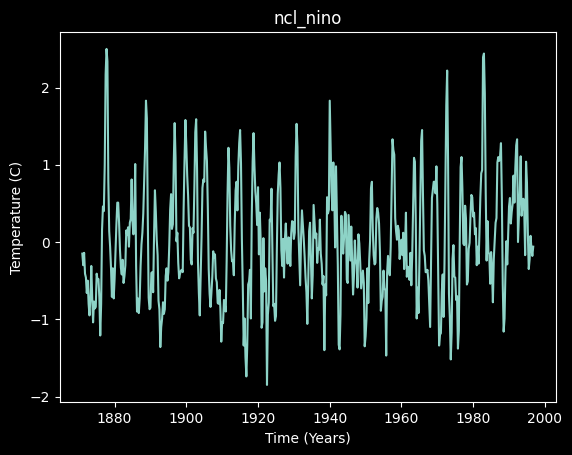

In [45]:
# Compare Output Coefficients
ncl_data = np.genfromtxt("data/ncl_csv.csv", skip_header=1, delimiter=',')
ncl_data = ncl_data[:,1]
time_range = (np.arange(0, len(ncl_data)) * dt) + time_0 # from 1871.00 to 1996.75
ncl_df = pd.DataFrame({'time (years)': time_range, 'temperature (C)': ncl_data})
ncl_df.head()
print(f"NCL dataframe is the same as the data from paos = {np.all(ncl_df == sst_df)}")

fig, ax = plt.subplots()
fig = plt.plot(ncl_df["time (years)"], ncl_df["temperature (C)"])
plt.title("ncl_nino")
plt.xlabel("Time (Years)")
plt.ylabel("Temperature (C)")
plt.show()

## PyWavelets Output

In [46]:
wavelet_mother = "cmor1.5-1.0"

'''NCL
  mother = 0             ; Morlet wavelet
  param  = 6.0           ; common for Morlet
  dt     = 0.25          
  s0     = 0.25
  dj     = 0.25          ; 4 sub-octaves per octave
  jtot   = 44            ; =subScale*11      
'''

s0 = 0.25
dt = 0.25
dj = 0.25
jtot = 44
scales = np.arange(1, jtot + 1)

wavelet_coeffs, freqs = pywt.cwt(data=sst_data,
                                 scales=scales,
                                 wavelet=wavelet_mother)
# Shape of wavelet transform
print(f"size {wavelet_coeffs.shape} with {wavelet_coeffs.shape[0]} scales and {wavelet_coeffs.shape[1]} time steps")
print(f"x-axis (time) be default is: {wavelet_coeffs.shape[1]}")
print(f"y-axis (scale) be default is: {wavelet_coeffs.shape[0]}")

size (44, 504) with 44 scales and 504 time steps
x-axis (time) be default is: 504
y-axis (scale) be default is: 44


In [47]:
pd.DataFrame(wavelet_coeffs).head()

,0,1,2,3,4,5,6,7,8,9,...,494,495,496,497,498,499,500,501,502,503
0,-0.000952+0.016315j,0.002033+0.012233j,-0.000814+0.004280j,-0.001798+0.018004j,0.000564+0.019885j,0.001646+0.013634j,-0.000972+0.007223j,-0.001695+0.022292j,0.004822+0.011606j,0.004379-0.024071j,...,0.010627+0.004991j,0.001427-0.057738j,-0.015113+0.004300j,-0.003632+0.071097j,0.007393+0.054785j,0.007284-0.000020j,-0.001618-0.019174j,-0.003267+0.003733j,0.001837+0.007509j,0.001597-0.006995j
1,0.005304-0.011478j,-0.006581+0.031612j,0.004400-0.050115j,-0.001354+0.059140j,0.000257-0.061215j,0.000339+0.061404j,-0.002883-0.056660j,0.004891+0.043227j,-0.002147-0.030535j,-0.001994+0.031100j,...,-0.011303+0.161079j,-0.005424-0.172570j,0.018476+0.130327j,-0.016519-0.070377j,0.009548+0.028759j,-0.006567-0.003551j,0.003540-0.013563j,0.001565+0.016761j,-0.003811-0.006756j,0.001782-0.002987j
2,0.026042+0.034228j,-0.046968+0.011001j,0.007413-0.042000j,0.032733+0.013857j,-0.004599+0.027982j,-0.037730+0.005980j,-0.003535-0.054552j,0.074463+0.009983j,-0.026472+0.084263j,-0.095448-0.046417j,...,-0.205952+0.139689j,-0.064086-0.228831j,0.210074+0.016358j,-0.054308+0.138104j,-0.075814-0.037240j,0.004161-0.043373j,0.045453-0.020062j,0.024642+0.053397j,-0.056395+0.012307j,0.001875-0.045774j
3,-0.007727+0.050628j,-0.057717-0.013587j,0.022327-0.063764j,0.069359+0.034378j,-0.049886+0.075455j,-0.083000-0.068439j,0.088743-0.092407j,0.103030+0.108499j,-0.124718+0.112892j,-0.118948-0.134504j,...,-0.259031+0.160861j,-0.152160-0.292964j,0.305094-0.152023j,0.155984+0.294358j,-0.264549+0.159038j,-0.157133-0.222746j,0.176890-0.148263j,0.132730+0.133541j,-0.096641+0.112576j,-0.090560-0.067510j
4,-0.007795+0.017914j,-0.015344-0.005355j,0.003277-0.004497j,-0.012820+0.006358j,-0.023098-0.028563j,0.034092-0.050943j,0.078999+0.026105j,-0.004321+0.110023j,-0.125076+0.032924j,-0.077168-0.121829j,...,-0.174444-0.138000j,0.058667-0.262495j,0.292135-0.045777j,0.139481+0.272627j,-0.202216+0.222411j,-0.256642-0.125314j,0.037553-0.254961j,0.212462-0.028740j,0.065448+0.161305j,-0.104254+0.083556j


## NCL Output

In [49]:
# cmorB-C
# https://pywavelets.readthedocs.io/en/latest/ref/cwt.html#complex-morlet-wavelets
# B = bandwidth
# C = center frequency
import math
import cmath
B = 1.5
C = 1.0 # C * 2 * pi = approx 6 (morlet default)

def complex_morlet_pywavelets(time_step):
    part1 = np.power(math.pi*B, -1/4)
    part2 = math.exp(-np.power(time_step, 2)/B)
    part3 = cmath.exp(1j * 2 * math.pi * C * time_step)
    return part1 * part2 * part3

for time_step in sst_data:
    print(f"sst_data value = {time_step}")
    morlet_output = complex_morlet_pywavelets(time_step)
    print(f"pywavelets c-morlet output = {np.real(morlet_output)}")
    break

# NCL
# https://github.com/yyr/ncl/blob/a7d7f58d467db541157fc730a287547e9d521d5d/ni/src/lib/nfpfort/wavelet.f#L470C13-L470C55
# norm = SQRT(2.D0*pi*scale1/dt)*(pi**(-0.25D0))
##
# Reference: Tables 1 & 2 in
#            Torrence, C. and G. P. Compo, 1998: A Practical Guide to
#            Wavelet Analysis. <I>Bull. Amer. Meteor. Soc.</I>, 79, 61-78.
###

sst_data value = -0.15
pywavelets c-morlet output = 0.39300129833355385


In [51]:
with open("ncl/ncl_output.txt", "r") as f:
    lines = f.readlines()[30:]
    ncl_data = np.genfromtxt(lines, dtype="str")

# returns: #D array (wave) of 2 x scales x time steps
# real (0,:,:) and imaginary parts (1,:,:) 
# real [0, scale, timestep]
# imaginary [1, scale, timestep
# timestep = x (column)
# scale = y (row)
ncl_0_real = []
ncl_1_imaginary = []
for row in ncl_data:
    if int(row[0][1]) == 0:
        ncl_0_real.append(row[1])
    if int(row[0][1]) == 1:
        ncl_1_imaginary.append(row[1])

In [53]:
print(len(ncl_0_real))

22176


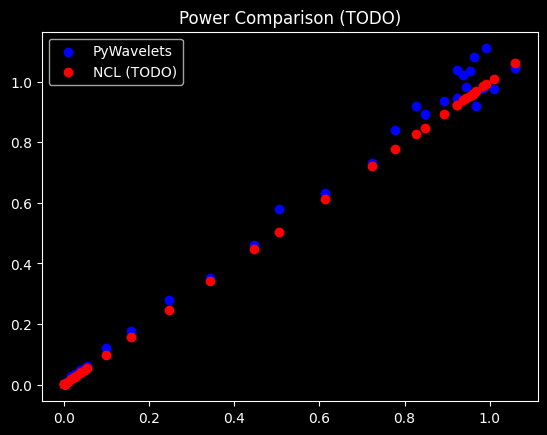

In [50]:
# Plot data
plt.style.use('dark_background')
fig, ax = plt.subplots()
power = np.power((abs(wavelet_coeffs)), 2)
ax.scatter(x=power[:,0],
            y=power[:,1],
           color="blue",
          label="PyWavelets")
ax.scatter(x=power[:,0],
            y=power[:,0],
           color="red",
          label="NCL (TODO)")
plt.title("Power Comparison (TODO)")
plt.legend()
plt.show()